In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "mean_energy": [], "standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["mean_energy"].append(mean_energy_alpha)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

# Histogram plots of distance 
## Comparison N=10

In [3]:
N = 10       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N10 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_NI_N10.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix
distances_NI_N10 = sampler_NI_N10.distance_samples.flatten()

wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N10 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_I_N10.sample(nsamples,
                              initial_positions, 
                              initial_alpha, 
                              scale=1.0, 
                              nchains=1, 
                              warm=True, 
                              warmup_iter=10000, 
                              tune=True,
                              tune_iter=10000,
                              tune_interval=500,
                              tol_tune=100,
                              optimize=False,
                              )
end = time.time()
print("Sampler elapsed time:", end - start)
distances_I_N10 = sampler_I_N10.distance_samples.flatten()

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 25.858173370361328
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 177.28587698936462


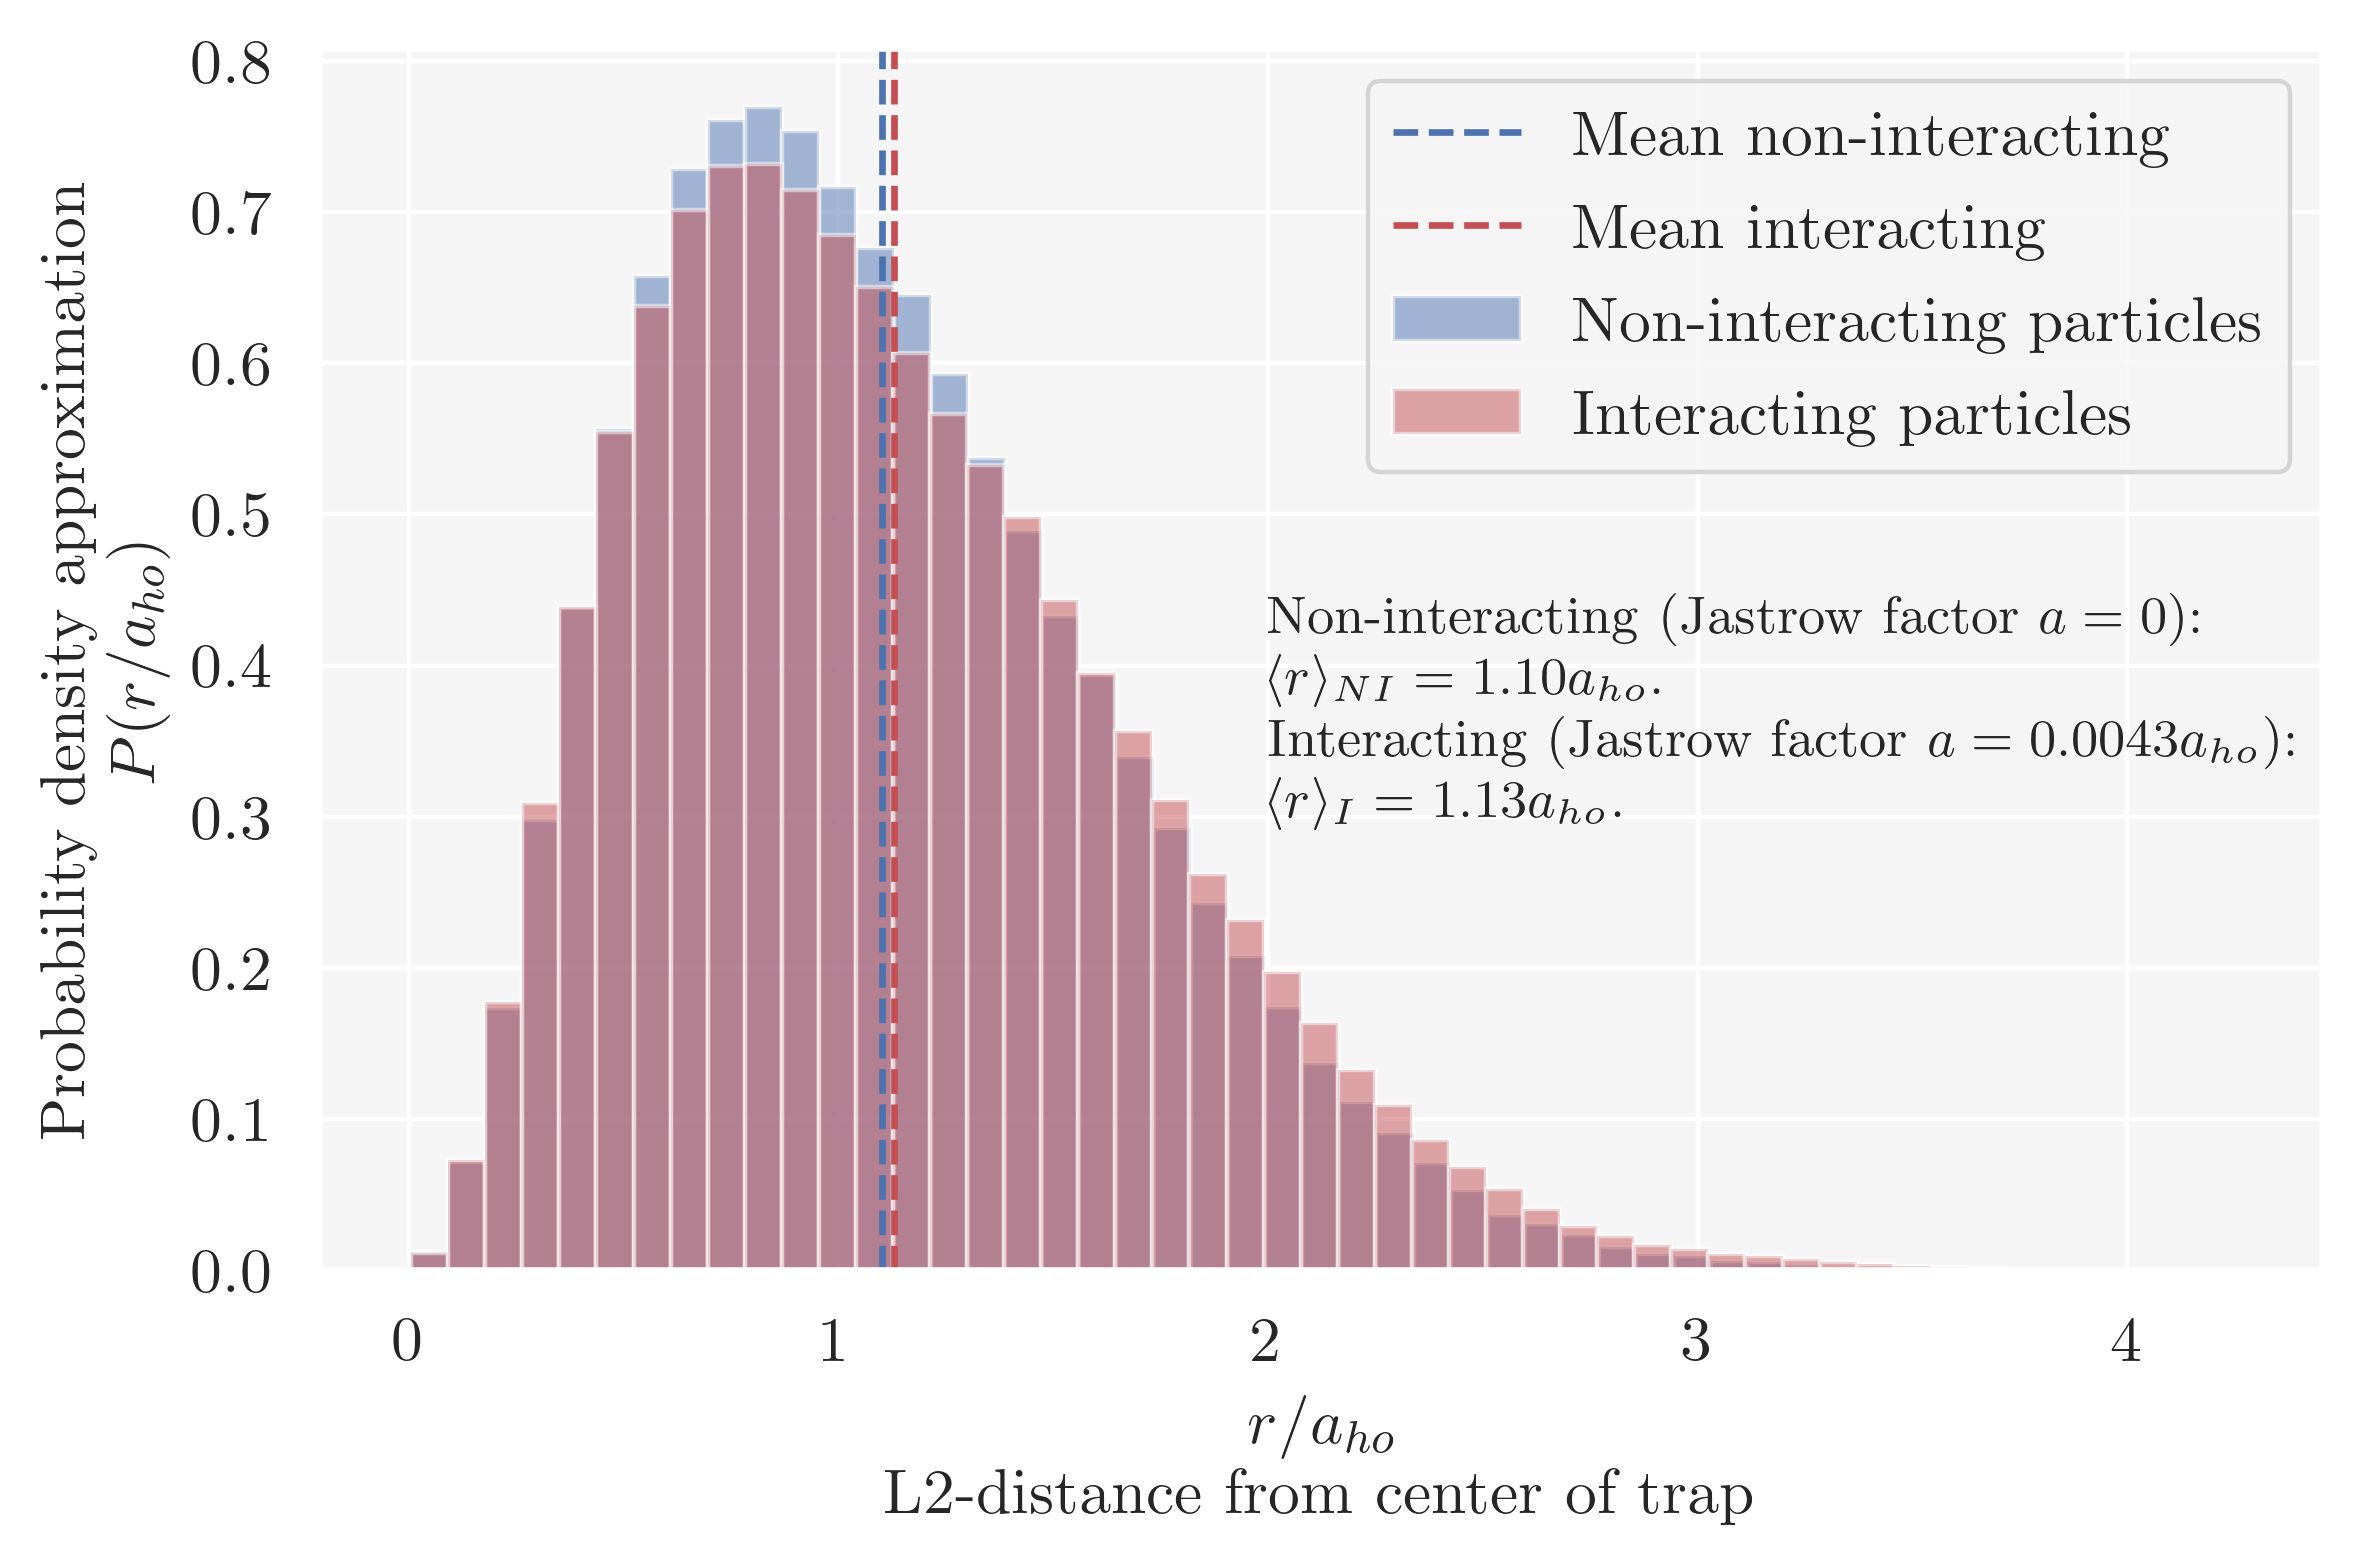

In [64]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N10, bins=np.linspace(np.min(distances_NI_N10), np.max(distances_NI_N10), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N10, bins=np.linspace(np.min(distances_I_N10), np.max(distances_I_N10), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N10)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N10))))
#plt.text(2.3, 0.42, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N10)))
#plt.text(2.3, 0.38, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N10)))
plt.text(2.0, 0.3, texstr)
ax.axvline(np.mean(distances_NI_N10), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N10), linestyle="--", color="r", label="Mean interacting")
plt.legend()

fig.savefig(fig_path("OBD_10.pdf"), bbox_inches='tight')

## Comparison N=50

In [5]:
N = 50       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N50 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_NI_N50.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix
distances_NI_N50 = sampler_NI_N50.distance_samples.flatten()

wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N50 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_I_N50.sample(nsamples,
                              initial_positions, 
                              initial_alpha, 
                              scale=1.0, 
                              nchains=1, 
                              warm=True, 
                              warmup_iter=10000, 
                              tune=True,
                              tune_iter=10000,
                              tune_interval=500,
                              tol_tune=100,
                              optimize=False,
                              )
end = time.time()
print("Sampler elapsed time:", end - start)
distances_I_N50 = sampler_I_N50.distance_samples.flatten()

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 29.87003445625305
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 361.4858384132385


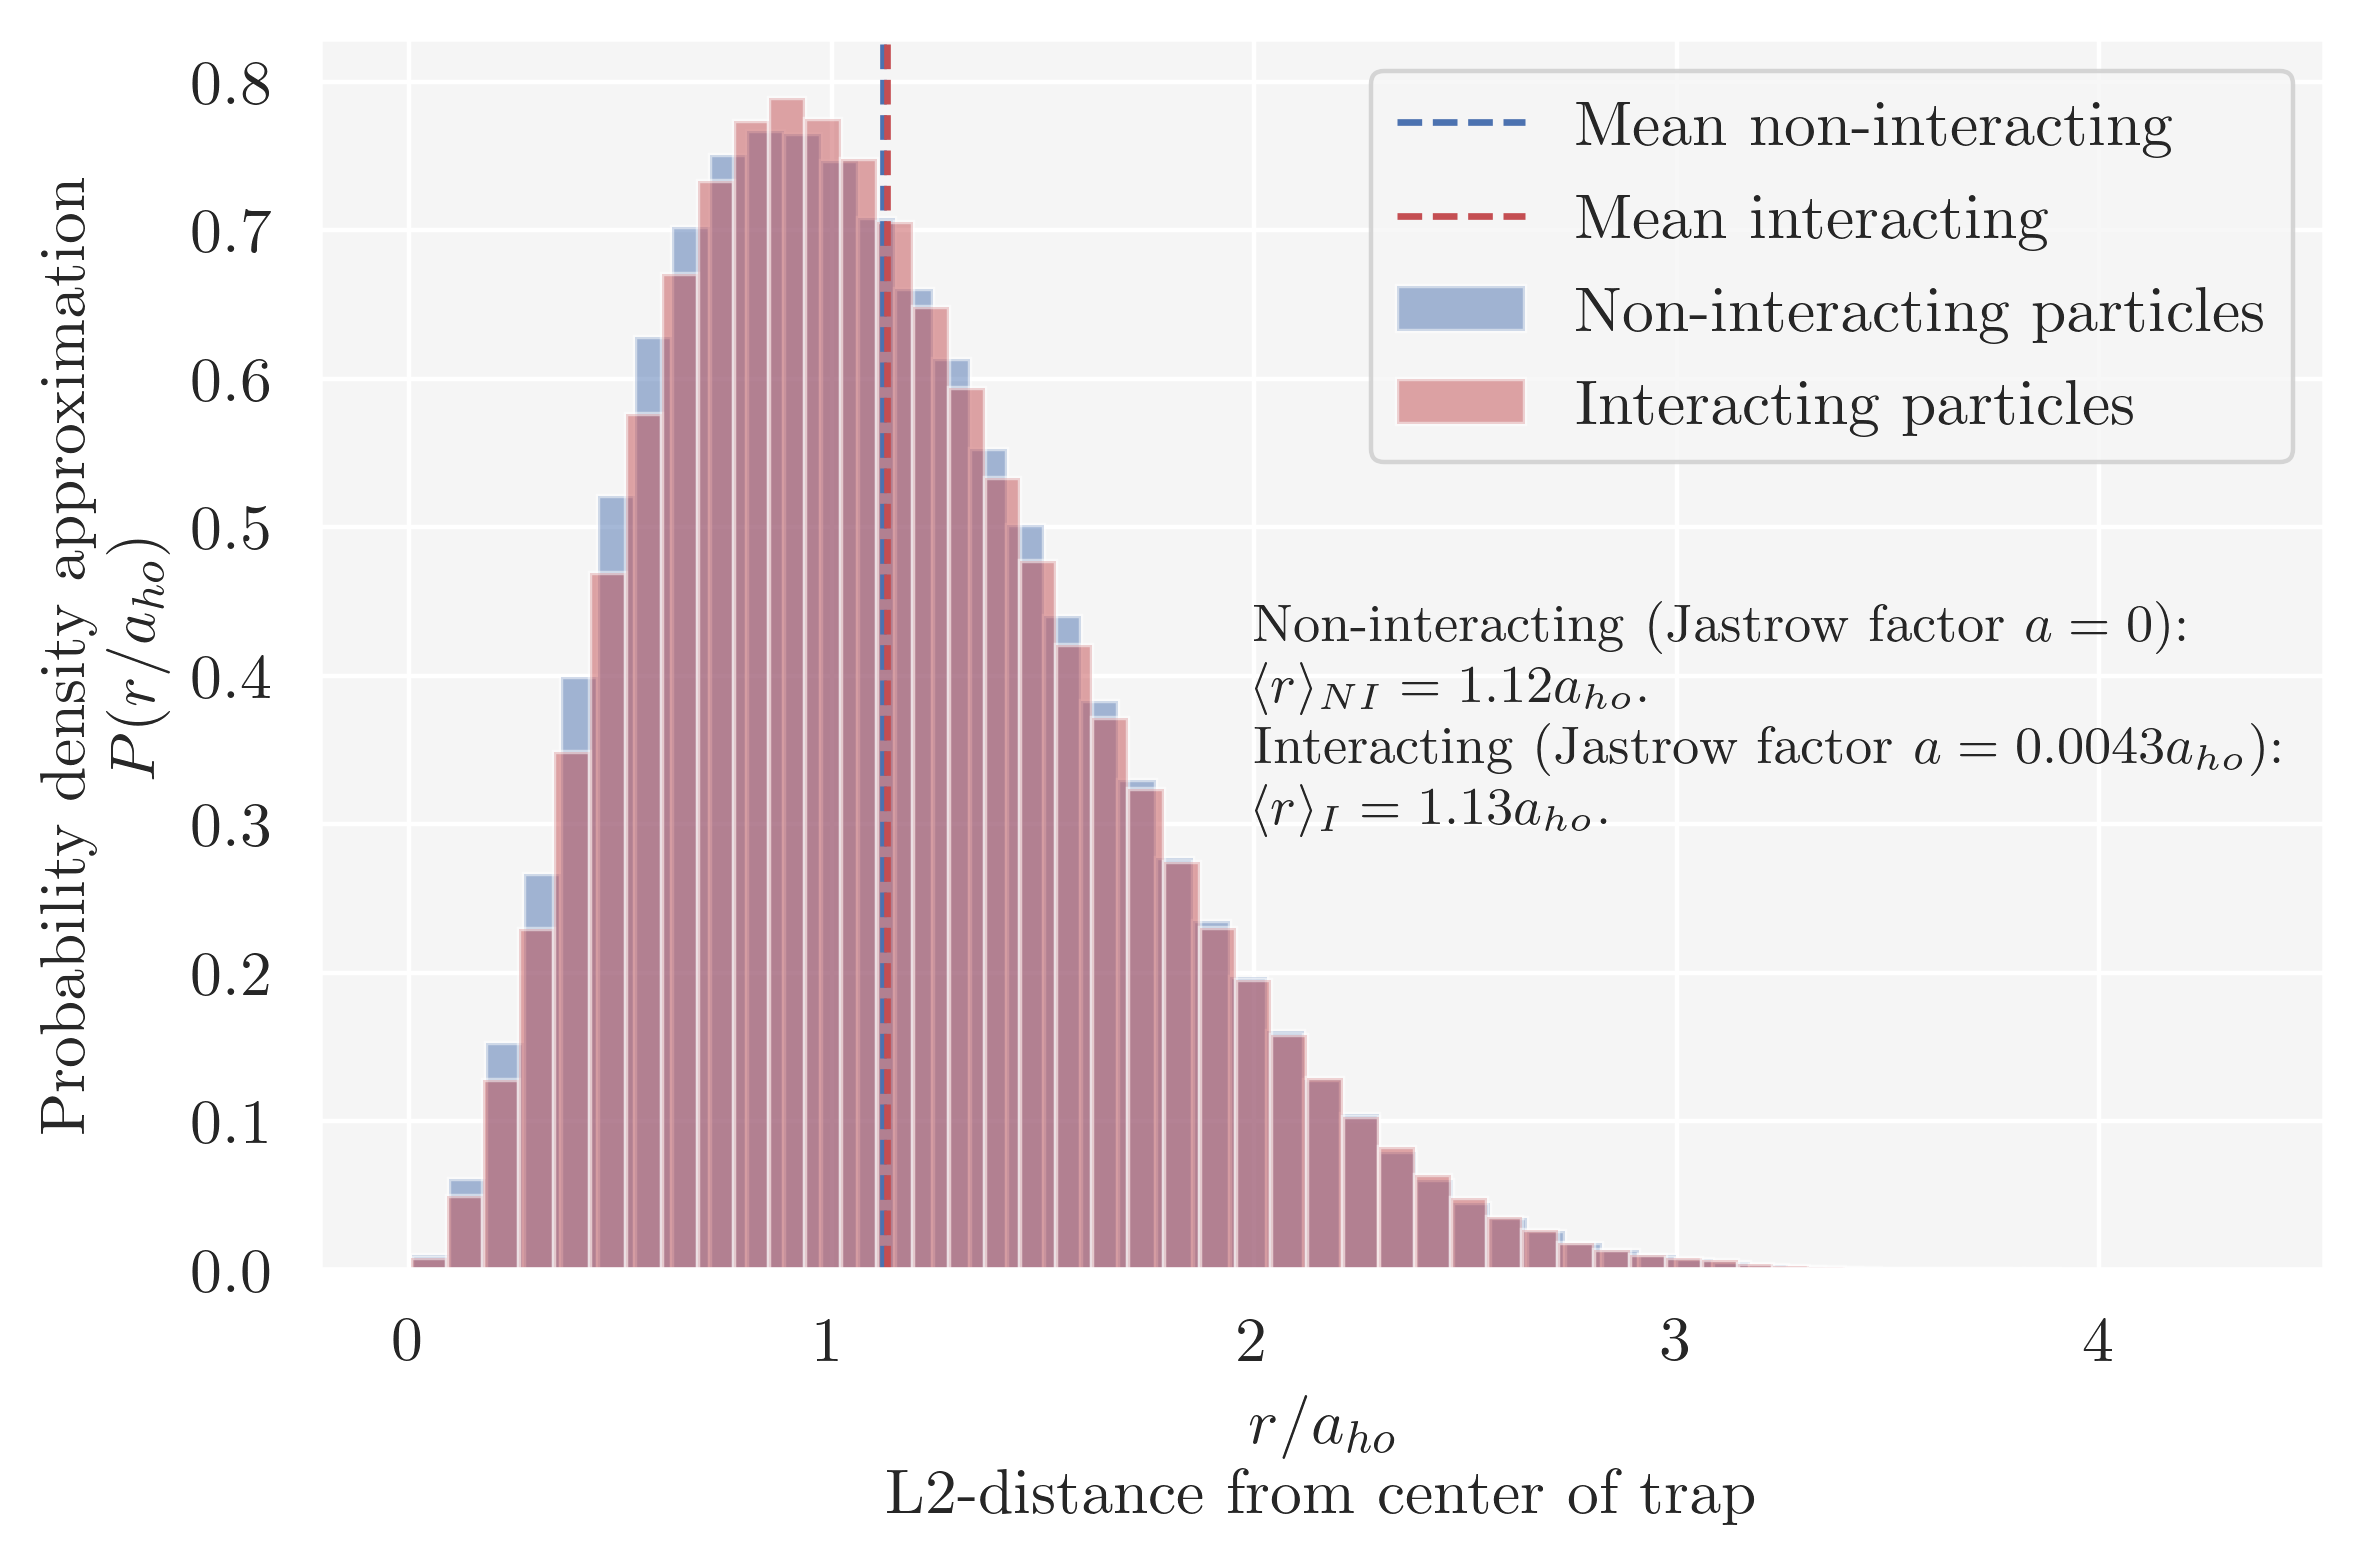

In [63]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N50, bins=np.linspace(np.min(distances_NI_N50), np.max(distances_NI_N50), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N50, bins=np.linspace(np.min(distances_I_N50), np.max(distances_I_N50), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
#plt.text(2.4, 0.45, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N50)))
#plt.text(2.4, 0.35, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N50)))
ax.axvline(np.mean(distances_NI_N50), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N50), linestyle="--", color="r", label="Mean interacting")
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N50)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N50))))
plt.text(2, 0.3, texstr)
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
plt.legend()

fig.savefig(fig_path("OBD_50.pdf"), bbox_inches='tight')

## Comparison N=100

In [10]:
N = 100       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N100 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_NI_N100.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix
distances_NI_N100 = sampler_NI_N100.distance_samples.flatten()

wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N100 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_I_N100.sample(nsamples,
                              initial_positions, 
                              initial_alpha, 
                              scale=1.0, 
                              nchains=1, 
                              warm=True, 
                              warmup_iter=10000, 
                              tune=True,
                              tune_iter=10000,
                              tune_interval=500,
                              tol_tune=100,
                              optimize=False,
                              )
end = time.time()
print("Sampler elapsed time:", end - start)
distances_I_N100 = sampler_I_N100.distance_samples.flatten()

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 25.97825598716736
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 696.9370608329773


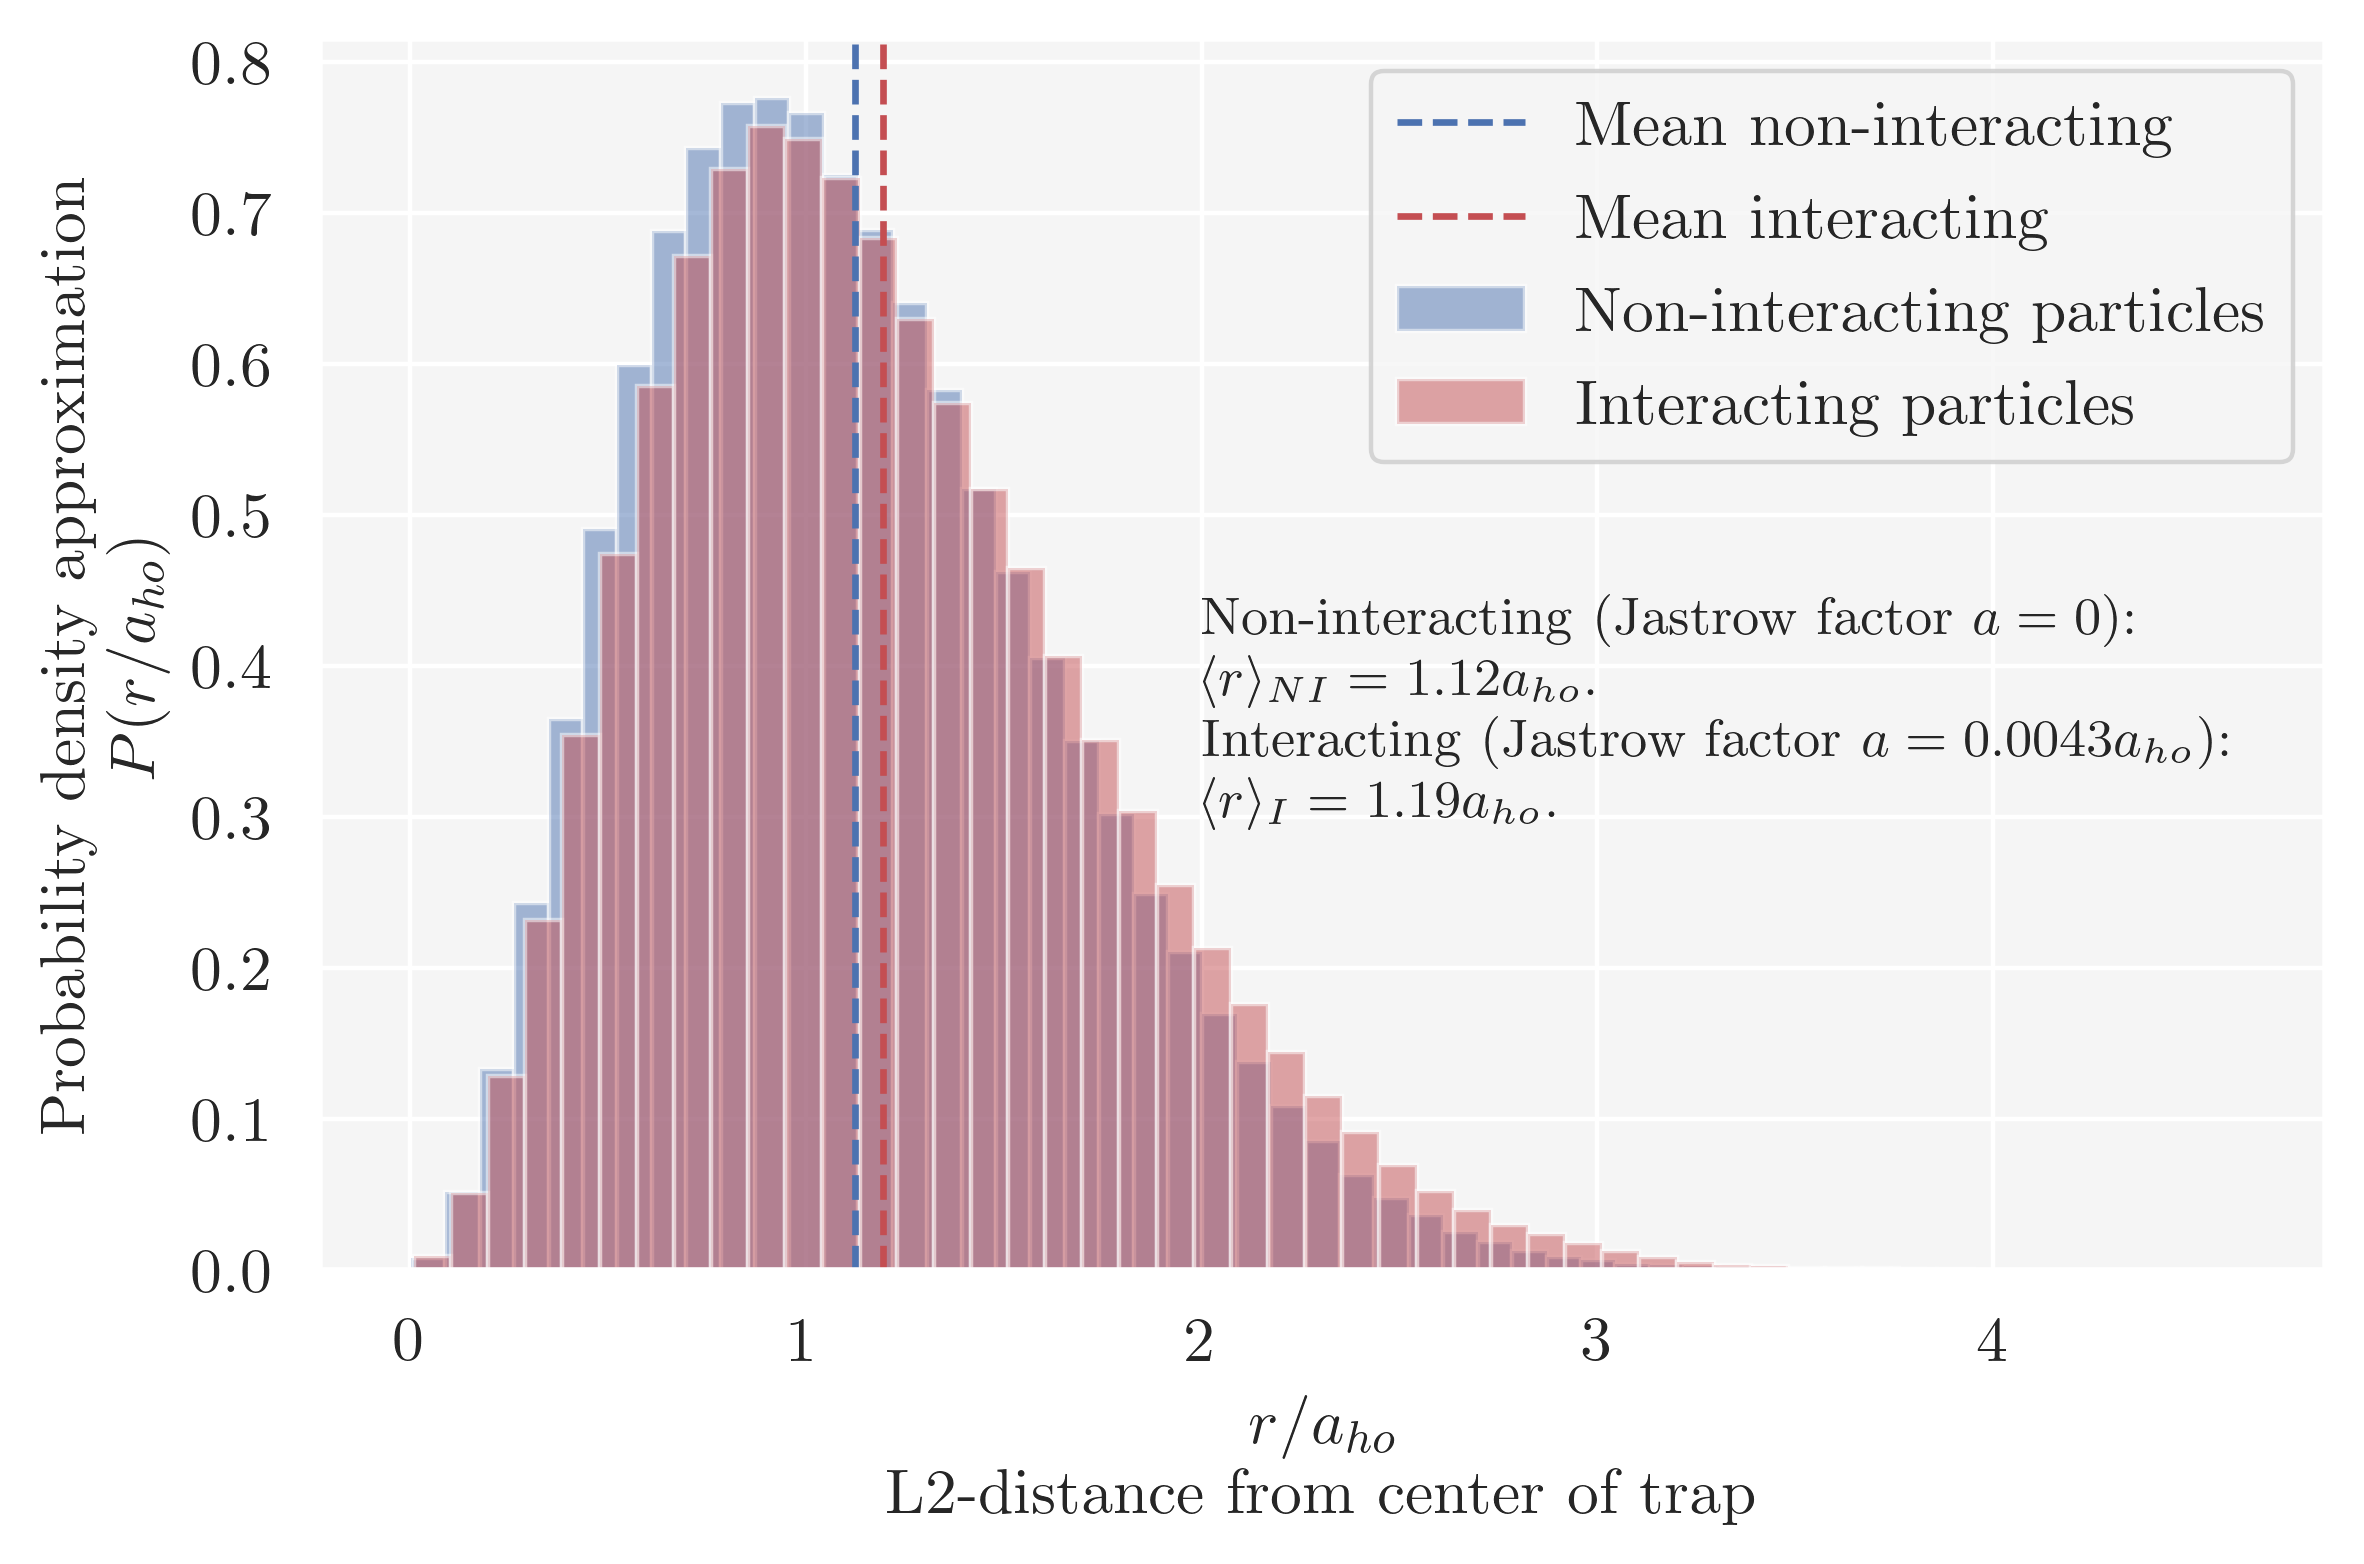

In [62]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N100, bins=np.linspace(np.min(distances_NI_N100), np.max(distances_NI_N100), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N100, bins=np.linspace(np.min(distances_I_N100), np.max(distances_I_N100), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
#plt.text(2.5, 0.45, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N100)))
#plt.text(2.5, 0.35, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N100)))
ax.axvline(np.mean(distances_NI_N100), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N100), linestyle="--", color="r", label="Mean interacting")
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N100)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N100))))
plt.text(2, 0.3, texstr)
plt.legend()

fig.savefig(fig_path("OBD_100.pdf"), bbox_inches='tight')